In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import datetime

In [151]:
licor_IN_df = pd.read_csv("ML614_adentro.txt", sep="\t", skiprows = [0])
licor_OUT_df = pd.read_csv("ML614_afuera.txt", sep="\t", skiprows = [0])
dohm_IN_df = pd.read_csv("deltaohmML614adenro.csv", sep=";")
dohm_OUT_df = pd.read_csv("deltaphmML614afuera.csv", sep=";")

licor_IN_df.drop(['Unnamed: 8'], axis = 1 , inplace = True)
licor_OUT_df.drop(['Unnamed: 8'], axis = 1 , inplace = True)

dohm_IN_df['Hr'] = [hr[11:] for hr in dohm_IN_df["Adquisición"]]

corr_tiempo_lic = 1/(2*3600)
corr_tiempo_dohm = 15/(3600)

In [178]:
def linear_reg_plot(C, corr_tiempo, start_idx=0, end_idx=-1):

    x = C[start_idx:end_idx].index.values*corr_tiempo
    y = C[start_idx:end_idx]

    x = x.reshape(len(x), 1)
    y = y.values.reshape(len(y), 1)

    regr = linear_model.LinearRegression().fit(x, y)
    
    p = plt.plot(x, regr.predict(x), linewidth=3, linestyle = '--')
    
    cordx = x[int(round(len(x)/2,0))]
    cordy = y[int(round(len(y)/2,0))]
    
    tau = round(-1/regr.coef_[0][0], 3)
    if tau > 0:
        plt.text(cordx*1.1, cordy*0.5, f'$Tau = {tau}$', 
                 color = p[0].get_color(), fontsize = 18, horizontalalignment='center')
    
    score.append(regr.score(x,y))
    coef.append(regr.coef_[0][0])
    inter.append(regr.intercept_[0])
    

def ach(c_start, c_end, c_ambien, dt):
    return (-1 * np.log( (c_end - c_ambien)/(c_start - c_ambien) ) )/(dt)


def comparative_plot(conc_array, stop_inyec_idx, open_door_idx, empty_room_idx, corr_tiempo, s, label):

    plt.figure(figsize=(15,10))

    plt.scatter(conc_array[0:stop_inyec_idx].index.values*corr_tiempo,
                conc_array[0:stop_inyec_idx], s =s, alpha = 1,
               label = 'Inyección de CO2')

    plt.scatter(conc_array[stop_inyec_idx:open_door_idx].index.values*corr_tiempo, 
                conc_array[stop_inyec_idx:open_door_idx], s =s, alpha = 1,
               label = 'Estabilización de concentración')

    plt.scatter(conc_array[open_door_idx:empty_room_idx].index.values*corr_tiempo, 
                conc_array[open_door_idx:empty_room_idx], s =s, alpha = 1,
               label = 'Apertura de puertas con habitantes')
                
    plt.scatter(conc_array[empty_room_idx:].index.values*corr_tiempo, 
                conc_array[empty_room_idx:], s =s, alpha = 1,
               label = 'Sin habitantes')

    plt.legend(fontsize = 15, markerscale = 7, frameon = False, loc='lower right')
    
    linear_reg_plot(conc_array, corr_tiempo, 
                    0,stop_inyec_idx)

    linear_reg_plot(conc_array, corr_tiempo, 
                    stop_inyec_idx, open_door_idx)

    linear_reg_plot(conc_array, corr_tiempo, 
                    open_door_idx, empty_room_idx)

    linear_reg_plot(conc_array, corr_tiempo, 
                    empty_room_idx)

    linear_reg_plot(conc_array, corr_tiempo, 
                    open_door_idx)
    
    plt.xlabel('Tiempo [hrs]', fontsize = 20)
    plt.ylabel(label, fontsize=20)
    plt.title('Explerimento de ventilación de CO2 | ML614', fontsize = 25)

# LICOR

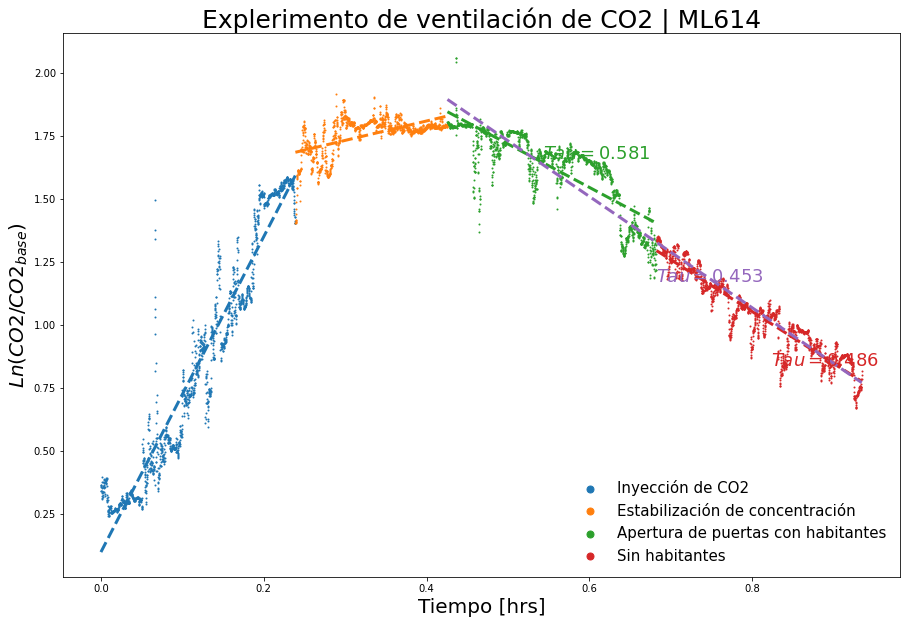

In [171]:
score = []
coef = []
inter = []

stop_inyec_idx_lic = licor_IN_df[licor_IN_df["System_Time_(h:m:s)"]=='15:57:48'].index[-1]
open_door_idx_lic = licor_IN_df[licor_IN_df["System_Time_(h:m:s)"]=='16:9:00'].index[-1]
empty_room_idx_lic = licor_IN_df[licor_IN_df["System_Time_(h:m:s)"]=='16:25:30'].index[-1]

outdoor_CO2mean_lic = np.mean(licor_OUT_df["CO₂_(µmol_mol⁻¹)"][200:])
log_CO2_licor_norm = np.log(licor_IN_df["CO₂_(µmol_mol⁻¹)"]/outdoor_CO2mean_lic)


comparative_plot(log_CO2_licor_norm, stop_inyec_idx_lic, open_door_idx_lic, empty_room_idx_lic, corr_tiempo_lic, 1, '$Ln( CO2/CO2_{base} )$')

In [154]:
coef

[6.258038275867055,
 0.7703207088831607,
 -1.7207954016364904,
 -2.058843595475859,
 -2.2082623337202687]

In [155]:
# Mitades de minuto
tau = [-1/tau for tau in coef]
tau_min = [t*60 for t in tau]
tau_min

[-9.5876690673783,
 -77.8896364956749,
 34.867596660788095,
 29.14257310844064,
 27.170684879145565]

## ACH licor

In [156]:
C_st_opendoor_licor = licor_IN_df["CO₂_(µmol_mol⁻¹)"][open_door_idx_lic]
C_st_empty_licor = licor_IN_df["CO₂_(µmol_mol⁻¹)"][empty_room_idx_lic]
C_st_end_licor = licor_IN_df["CO₂_(µmol_mol⁻¹)"][len(licor_IN_df["CO₂_(µmol_mol⁻¹)"])-1]


dt_total =  pd.to_datetime('16:41:50') - pd.to_datetime('16:09:10')

ach_licor_tot = ach(C_st_opendoor_licor, C_st_end_licor, outdoor_CO2mean_lic, dt_total.total_seconds()/3600)
ach_licor_tot 

2.5573412565602474

## Normalización larga licor

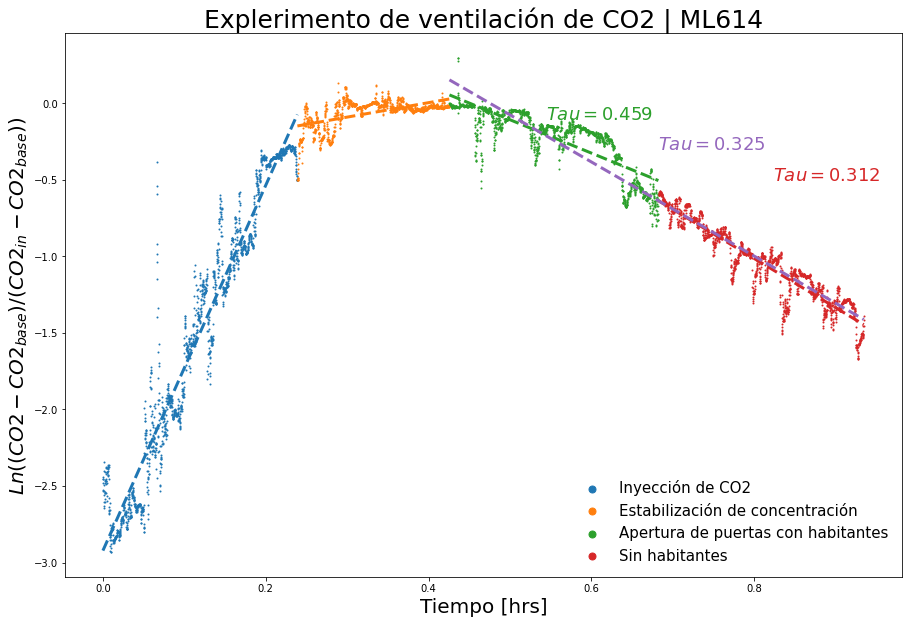

In [179]:
log_licor_normRIC = np.log((licor_IN_df["CO₂_(µmol_mol⁻¹)"]-outdoor_CO2mean_lic)/
                           (C_st_opendoor_licor-outdoor_CO2mean_lic))

score = []
coef = []
inter = []

comparative_plot(log_licor_normRIC, stop_inyec_idx_lic, open_door_idx_lic, empty_room_idx_lic, corr_tiempo_lic, 1, '$Ln( (CO2-CO2_{base})/(CO2_{in}-CO2_{base}) )$')

In [180]:
coef

[11.928753068523381,
 0.944506266497745,
 -2.1790457559429295,
 -3.209092247764604,
 -3.0741236947918282]

In [181]:
# Mitades de minuto
tau = [-1/tau for tau in coef]
tau_min = [t*60 for t in tau]
tau_min

[-5.029863528512724,
 -63.52525348771019,
 27.534988577620048,
 18.696876053281088,
 19.517757239779204]

In [182]:
tau

[-0.0838310588085454,
 -1.0587542247951698,
 0.45891647629366744,
 0.3116146008880181,
 0.32529595399632005]

# Deltaohm

In [161]:
stop_inyec_idx_dohm = dohm_IN_df[dohm_IN_df["Hr"]=='15:57:40'].index[0]
open_door_idx_dohm = dohm_IN_df[dohm_IN_df["Hr"]=='16:09:10'].index[0]
empty_room_idx_dohm = dohm_IN_df[dohm_IN_df["Hr"]=='16:25:40'].index[0]

log_CO2_dohm =dohm_IN_df["CO2 ( ppm )"]

outdoor_CO2mean_dohm = np.mean(dohm_OUT_df["CO2 ( ppm )"])

log_CO2_dohm_norm = np.log(log_CO2_dohm/outdoor_CO2mean_dohm)

In [162]:
score = []
coef = []
inter = []
    
comparative_plot(log_CO2_dohm_norm, stop_inyec_idx_dohm, open_door_idx_dohm, empty_room_idx_dohm, corr_tiempo_dohm, 10)

TypeError: comparative_plot() missing 1 required positional argument: 'label'

In [ ]:
coef

In [ ]:
tau = [-1/tau for tau in coef]
tau_min = [t*60 for t in tau]
tau_min

# ACH deltaohm

In [ ]:
C_st_opendoor_d = dohm_IN_df["CO2 ( ppm )"][open_door_idx_dohm]
C_st_empty_d = dohm_IN_df["CO2 ( ppm )"][empty_room_idx_dohm]
C_st_end_d = dohm_IN_df["CO2 ( ppm )"][len(dohm_IN_df["CO2 ( ppm )"])-1]

dt_total =  pd.to_datetime('16:41:50') - pd.to_datetime('16:09:10')

ach_d_tot = ach(C_st_opendoor_licor, C_st_end_licor, outdoor_CO2mean_lic, dt_total.total_seconds()/3600)
ach_d_tot 

## Normalización larga deltaohm

In [ ]:
log_dohm_normRIC = np.log((dohm_IN_df["CO2 ( ppm )"]-outdoor_CO2mean_dohm)/
                           (C_st_opendoor_d-outdoor_CO2mean_dohm))

score = []
coef = []
inter = []

comparative_plot(log_dohm_normRIC, stop_inyec_idx_dohm, open_door_idx_dohm, empty_room_idx_dohm, corr_tiempo_dohm, 2)

In [ ]:
tau = [-1/tau for tau in coef]
tau_min = [t*60 for t in tau]
tau_min

# Comparación entre equipos

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(dohm_IN_df["CO2 ( ppm )"].index.values*corr_tiempo_dohm, dohm_IN_df["CO2 ( ppm )"])
plt.plot(licor_IN_df["CO₂_(µmol_mol⁻¹)"].index.values*corr_tiempo_lic, licor_IN_df["CO₂_(µmol_mol⁻¹)"])


In [ ]:
plt.figure(figsize=(20,15))
plt.plot(log_CO2_licor_norm.index.values*corr_tiempo_lic, log_CO2_licor_norm)
plt.plot(log_CO2_dohm_norm.index.values*corr_tiempo_dohm, log_CO2_dohm_norm)
